# Rock type classification

This is a simple example of classification of rock types using Scikit-Learn lib. We take the major and some trace elements as features in order to classify some rock samples. The data base is obtained from georoc : http://georoc.mpch-mainz.gwdg.de/.


 Antoine Lucas (lucas@ipgp.fr) 
 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


We need to arrange the data in a nice way. We change the label into interger ans we replace some Nans with 0 (although this may not be ideal)

In [2]:
def read_rocks(filename, features=None):

    # Read the data
    data = pd.read_csv(filename, sep=";")

    # Rename the columns
    data.columns = [column.title() for column in data.columns]
    data["Rock Type"] = data["Rock Type"].str.lower()
    data["Rock Type"] = data["Rock Type"].str.replace(" ", "_")

    # If features is None, use all columns
    if features is None:
        features = data.columns[1:]
    else:
        features = data.columns[features]

    # Normalize the data
    # data[features] = (data[features] - data[features].mean()) / data[
    #     features
    # ].std()

    # Get samples
    samples = pd.concat(
        (
            data[features],
            data[features]
            + np.random.normal(0, 0.05, size=data[features].shape),
            data[features]
            + np.random.normal(0, 0.05, size=data[features].shape),
        )
    ).reset_index(drop=True)

    # Get labels
    labels = pd.concat((data["Rock Type"], data["Rock Type"], data["Rock Type"])).reset_index(
        drop=True
    )

    return samples, labels


In [3]:
def classify(model, x_train, x_test, y_train, y_test, name, show=True):
    
    # Fit the model
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    # Print the accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
    # Plot the confusion matrix
    if show is True:
        ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

In [4]:
x, y = read_rocks(filename="RockData2.csv")

Now, we want to train our model, so we split the data set into a training set and a test set.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=36)

We instantiate the model (using the default parameters)

In [6]:
for index, model in enumerate(classifiers):

    classify(
        model=model,
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        name=model.__class__.__name__,
        show=False,
    )

Accuracy (test) for KNeighborsClassifier: 94.0% 
Accuracy (test) for SVC: 75.2% 
Accuracy (test) for SVC: 97.4% 


array([[<AxesSubplot:title={'center':'Sio2(Wt%)'}>,
        <AxesSubplot:title={'center':'Tio2(Wt%)'}>],
       [<AxesSubplot:title={'center':'Al2O3(Wt%)'}>,
        <AxesSubplot:title={'center':'Cao(Wt%)'}>],
       [<AxesSubplot:title={'center':'Mgo(Wt%)'}>, <AxesSubplot:>]],
      dtype=object)

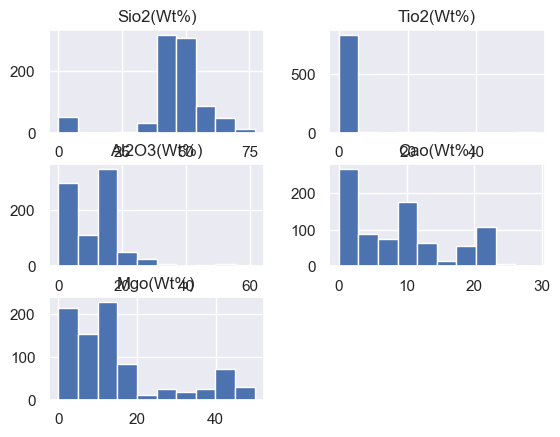

In [89]:
x.hist()

Now we evaluate the results by analysing the confusion matrix:

In [56]:
print("Accuracy on test data: {:.2f}".format(model.score(x_test, y_test)))

Accuracy on test data: 0.72


['volcanic_rock' 'mantle_xenolith' 'plutonic_rock' 'metamorphic_rock']


/Users/seydoux/Documents/Work/anaconda/envs/scientific_computing/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 640x480 with 0 Axes>

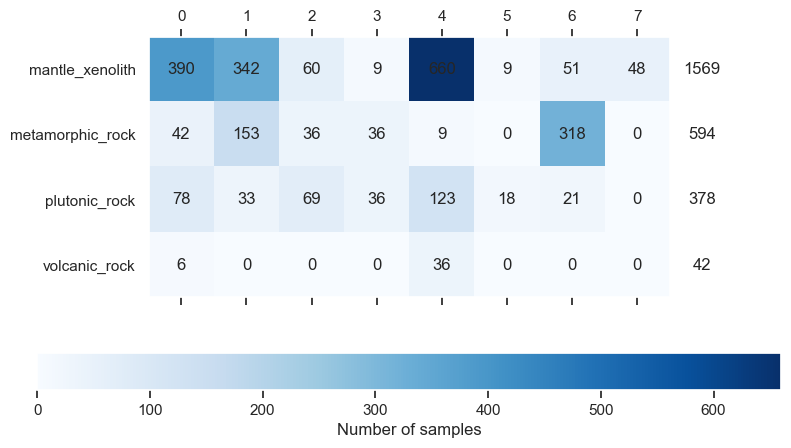

In [200]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=8)
model.fit(x)
y_pred = model.predict(x)

print(y.unique())

y_compare = pd.DataFrame({"y": y, "y_pred": y_pred})
matrix = np.zeros((len(y.unique()), len(np.unique(y_pred))))
for i, rock_type in enumerate(y.unique()):
    for j, category in enumerate(np.unique(y_pred)):
        count = y_compare[(y_compare["y"] == rock_type) & (y_compare["y_pred"] == category)].shape[0]
        matrix[i, j] = count
    
plt.figure()
plt.matshow(matrix, cmap=plt.cm.Blues)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, int(matrix[i, j]), va="center", ha="center")


# Add a column with the sum of each row
matrix = np.hstack((matrix, matrix.sum(axis=1).reshape(-1, 1)))
# Plot the values on the right
for i in range(matrix.shape[0]):
    plt.text(matrix.shape[1] - 1, i, int(matrix[i, -1]), va="center", ha="center")

    
plt.colorbar(orientation="horizontal").set_label("Number of samples")
plt.xticks(np.arange(len(np.unique(y_pred))))
plt.yticks(np.arange(len(np.unique(y_test))))
plt.gca().set_yticklabels(np.unique(y_test))
plt.grid(False)
plt.show();

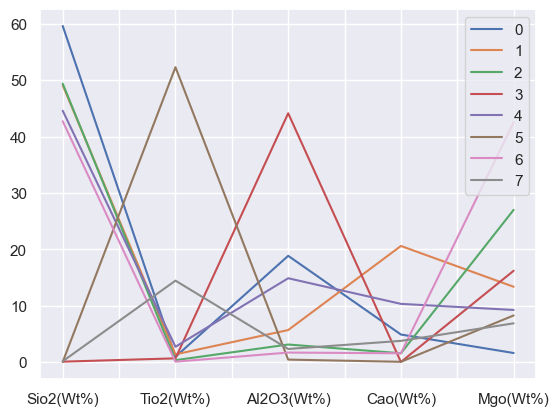

In [201]:
ax = x.loc[y_pred == 0].mean().plot(label=0)
for category in np.unique(y_pred)[1:]:
    x.loc[y_pred == category].mean().plot(ax=ax, label=category)
ax.legend()

<AxesSubplot:xlabel='Al2O3(Wt%)', ylabel='Tio2(Wt%)'>

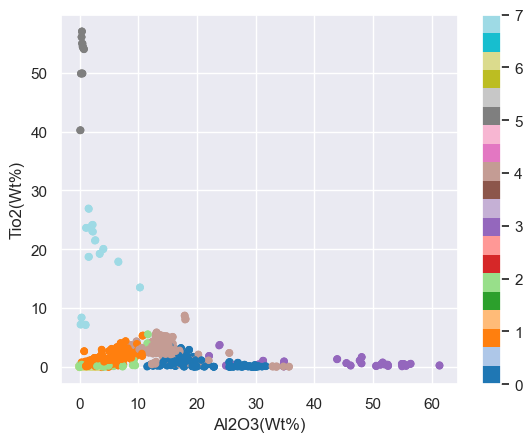

In [204]:
x.plot.scatter(x="Al2O3(Wt%)", y="Tio2(Wt%)", style=".", c=y_pred, cmap="tab20")